# Morphology Examples in Python (OpenCV)

Notebook ini berisi contoh-contoh implementasi morfologi citra sesuai materi:
1) Konektivitas & Pelabelan Komponen
2) Dilasi & Erosi
3) Opening & Closing
4) Hit-or-Miss
5) Boundary Extraction (∂X = X − (X ⊖ B))
6) Region Filling (mengisi lubang)
7) Thinning (penulangan / skeleton)
8) Morphological Reconstruction (termasuk Opening by Reconstruction)
9) Top-hat & Black-hat
10) Geodesic Dilation/Erosion (via reconstruction)
11) Bonus: Template Matching biner sederhana

**Cara pakai:** jalankan sel dari atas ke bawah. Jika belum punya dependensi, install dulu di bawah.

## Install (opsional, jalankan jika perlu)
Jika environment belum memiliki pustaka berikut:
```
pip install opencv-python matplotlib numpy
```
Untuk Windows PowerShell bisa jalankan:
```
pip install opencv-python
```
Tambahan opsional (jika ingin fungsi thinning bawaan OpenCV):
```
pip install opencv-contrib-python
```
Di sebagian lingkungan notebook, Anda mungkin perlu awali dengan `!`.

In [4]:
!pip install opencv-contrib-python

  Using cached opencv_contrib_python-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (19 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 MB 661.5 kB/s eta 0:00:00m eta 0:00:010:00:03


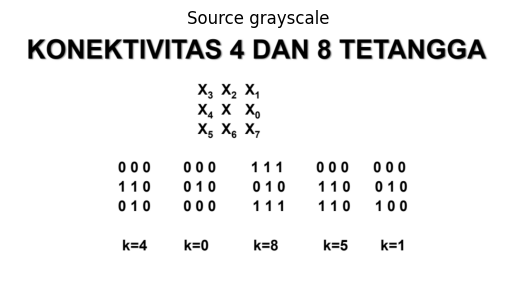

In [ ]:
# Import utama (OpenCV based)
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Helper tampilan: 1 plot per gambar (tanpa style/color khusus)
def show(title, image, is_bgr=False):
    plt.figure()
    plt.title(title)
    # Boolean -> uint8 grayscale
    if image.dtype == bool:
        img = image.astype(np.uint8) * 255
        plt.imshow(img, cmap='gray')
    else:
        if image.ndim == 2:
            plt.imshow(image, cmap='gray')
        else:
            img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) if is_bgr else image
            plt.imshow(img)
    plt.axis('off')
    plt.show()


bin_img = cv2.imread('Images/image1.png', cv2.IMREAD_GRAYSCALE)
show("Source grayscale", bin_img)


## 1) Konektivitas & Pelabelan Komponen
Menggunakan gambar `1-pelabelan.jpg` (dibinarisasi Otsu) bila tersedia.
- `cv2.connectedComponents` menghasilkan label dengan 4-connectivity (default) atau 8-connectivity.
- Untuk 8-neighbors gunakan parameter `connectivity=8`.

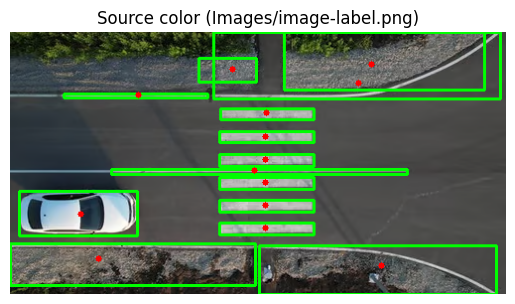

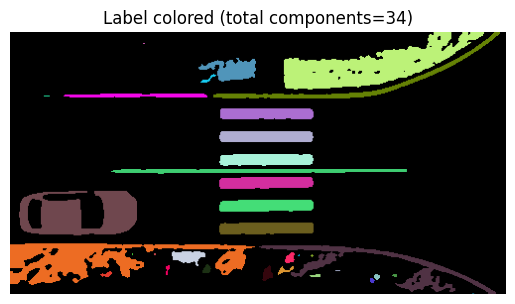

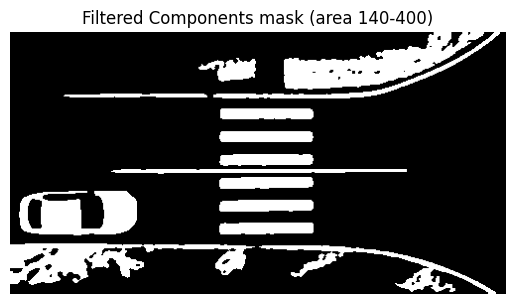

In [ ]:
# Analisis komponen terhubung (inline, tanpa cv2.imshow)
import cv2
import numpy as np

# Pakai gambar yang sama untuk konsistensi (coba 1-pelabelan.jpg, fallback image.png)
img = None
for cand in [ 'Images/image-label.png']:
    tmp = cv2.imread(cand)
    if tmp is not None:
        img = tmp
        src_name = cand
        break
if img is None:
    raise RuntimeError("Tidak menemukan 'image.png'.")

gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray_img, (7,7), 0)
threshold = cv2.threshold(blurred, 0, 255,  cv2.THRESH_OTSU)[1]
# threshold = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

analysis = cv2.connectedComponentsWithStats(threshold, 4, cv2.CV_32S)
(totalLabels, label_ids, values, centroid) = analysis

# Visualisasi label berwarna
label_vis = np.zeros((*label_ids.shape, 3), dtype=np.uint8)
colors = np.random.default_rng(1).integers(0, 255, (totalLabels, 3), dtype=np.uint8)
for lab in range(1, totalLabels):
    label_vis[label_ids == lab] = colors[lab]

# Filter & anotasi
output = np.zeros(gray_img.shape, dtype=np.uint8)
annotated = img.copy()
for i in range(1, totalLabels):
    area = values[i, cv2.CC_STAT_AREA]
    if 400 < area < 40000:
        x1 = values[i, cv2.CC_STAT_LEFT]; y1 = values[i, cv2.CC_STAT_TOP]
        w  = values[i, cv2.CC_STAT_WIDTH]; h  = values[i, cv2.CC_STAT_HEIGHT]
        (X, Y) = centroid[i]
        cv2.rectangle(annotated, (x1, y1), (x1 + w, y1 + h), (0, 255, 0), 2)
        cv2.circle(annotated, (int(X), int(Y)), 3, (0, 0, 255), -1)
        componentMask = (label_ids == i).astype("uint8") * 255
        output = cv2.bitwise_or(output, componentMask)

show(f"Source color ({src_name})", annotated, is_bgr=True)
# show("Grayscale", gray_img)
# show("Blurred (7x7)", blurred)
# show("Threshold (INV + Otsu)", threshold)
show(f"Label colored (total components={totalLabels-1})", label_vis, is_bgr=True)
show("Filtered Components mask (area 140-400)", output)


## 2) Dilasi & Erosi
Menggunakan `cv2.dilate` dan `cv2.erode` dengan structuring element buatan `cv2.getStructuringElement`.

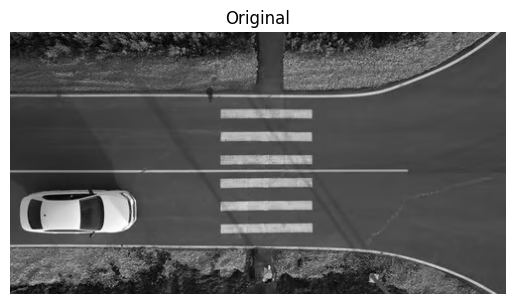

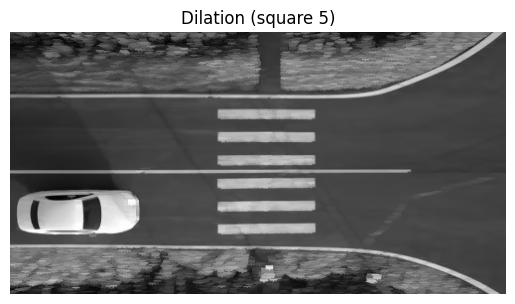

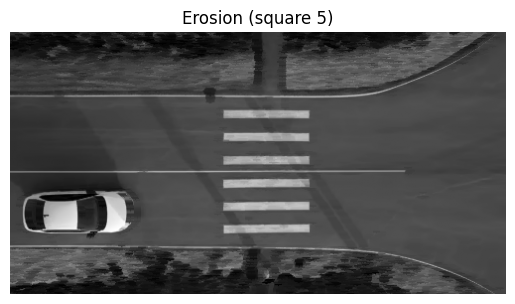

In [ ]:
se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,2))
dil = cv2.dilate(gray_img, se, iterations=1)
ero = cv2.erode(gray_img, se, iterations=1)
show("Original", gray_img)
show("Dilation (square 5)", dil)
show("Erosion (square 5)", ero)


## 3) Opening & Closing
- Opening = Erosi → Dilasi (menghilangkan noise kecil)
- Closing = Dilasi → Erosi (menutup lubang kecil)
Menggunakan `cv2.morphologyEx`.

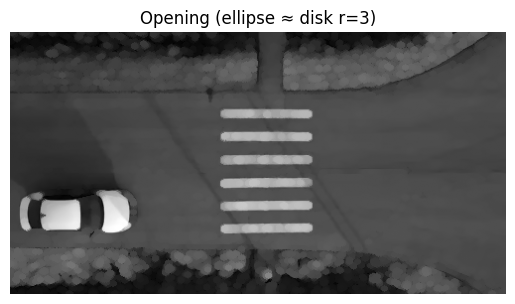

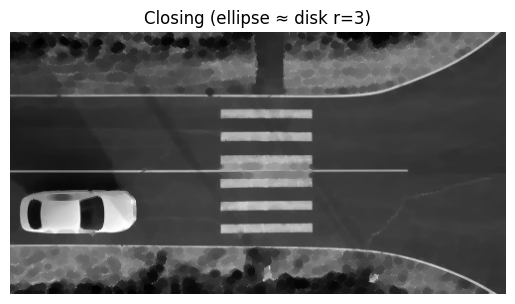

In [ ]:
se_oc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))  # approx disk r=3
op = cv2.morphologyEx(gray_img, cv2.MORPH_OPEN, se_oc)
cl = cv2.morphologyEx(gray_img, cv2.MORPH_CLOSE, se_oc)
show("Opening (ellipse ≈ disk r=3)", op)
show("Closing (ellipse ≈ disk r=3)", cl)


## 4) Hit-or-Miss
Menggunakan `cv2.morphologyEx(..., cv2.MORPH_HITMISS, kernel)`.
Kernel harus berisi nilai 1 (hit), -1 (miss), dan 0 (don't care). Berfungsi pada citra biner 0/1 atau 0/255 (akan dipetakan).

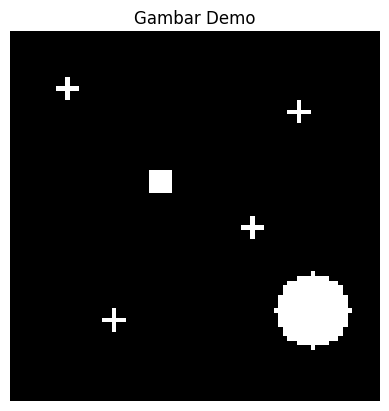

In [ ]:
# Inisialisasi gambar 80x80 dengan background (0)
image_demo = np.zeros((80, 80), dtype=np.uint8)

# 1. Buat pola Tanda Plus 5x5 (Pola ini tetap sama)
plus_pattern = np.array([
    [0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0],
    [1, 1, 1, 1, 1],
    [0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0]
], dtype=np.uint8)

# Tempatkan 4 buah pola plus (TARGET KITA)
image_demo[10:15, 10:15] = plus_pattern  # Target 1
image_demo[15:20, 60:65] = plus_pattern  # Target 2
image_demo[40:45, 50:55] = plus_pattern  # Target 3
image_demo[60:65, 20:25] = plus_pattern  # Target 4

# 2. Tambahkan Persegi 5x5 (distraktor)
image_demo[30:35, 30:35] = 1

# 3. Tambahkan Lingkaran (distraktor baru)
# cv2.circle(gambar, (pusat_X, pusat_Y), radius, warna, ketebalan)
# -1 berarti lingkaran diisi penuh
cv2.circle(image_demo, (65, 60), 8, 1, -1) # (x=65, y=60), radius 8

# Konversi 0/1 menjadi 0/255 yang diharapkan OpenCV
image_input = image_demo * 255

# Tampilkan gambar demo baru
show("Gambar Demo", image_input)

In [ ]:
kernel_hitmiss_plus = np.array([
    [-1, -1,  1, -1, -1],
    [-1, -1,  1, -1, -1],
    [ 1,  1,  1,  1,  1],
    [-1, -1,  1, -1, -1],
    [-1, -1,  1, -1, -1]
], dtype=np.int8) # Tipe data harus int8 (signed)

print("Kernel Hit-or-Miss 5x5 (Tanda Plus):")
print(kernel_hitmiss_plus)

Kernel Hit-or-Miss 5x5 (Tanda Plus):
[[-1 -1  1 -1 -1]
 [-1 -1  1 -1 -1]
 [ 1  1  1  1  1]
 [-1 -1  1 -1 -1]
 [-1 -1  1 -1 -1]]


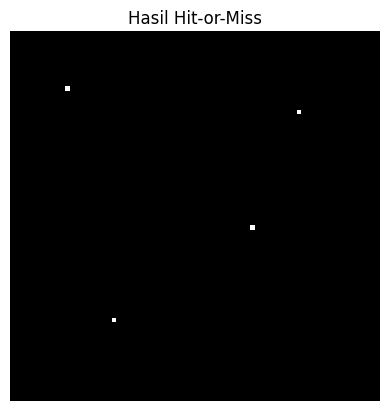

In [ ]:
output = cv2.morphologyEx(image_demo, cv2.MORPH_HITMISS, kernel_hitmiss_plus)

# Tampilkan hasilnya
show("Hasil Hit-or-Miss", output)

## 5) Boundary Extraction
Rumus: ∂X = X − (X ⊖ B) | Implementasi OpenCV: erosi lalu selisih (`cv2.subtract`).

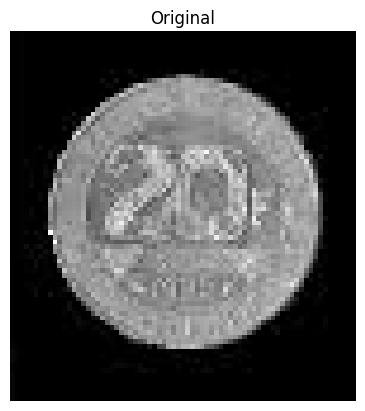

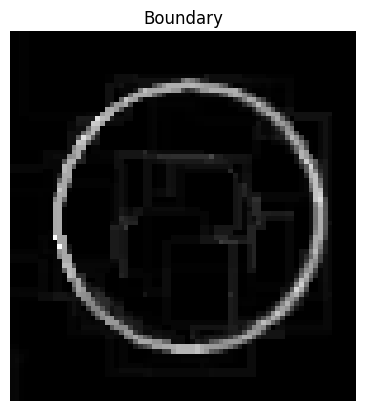

In [ ]:
img = cv2.imread('Images/koin.png', cv2.IMREAD_GRAYSCALE)
kernel = np.ones((10,10), np.uint8)

closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
erosion = cv2.erode(closing, kernel, iterations=1)

boundary = cv2.subtract(closing, erosion)
show("Original", img)
show("Boundary", boundary)

## 6) Region Filling (mengisi lubang)
Menggunakan teknik flood fill pada background lalu digabungkan kembali dengan objek.

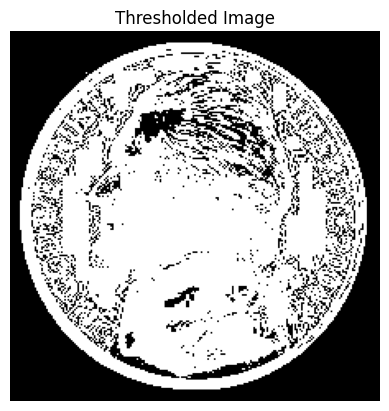

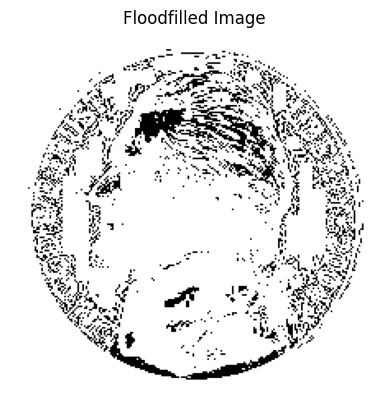

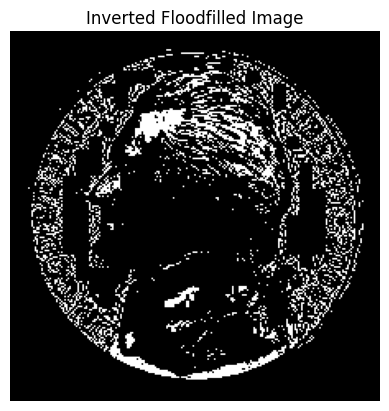

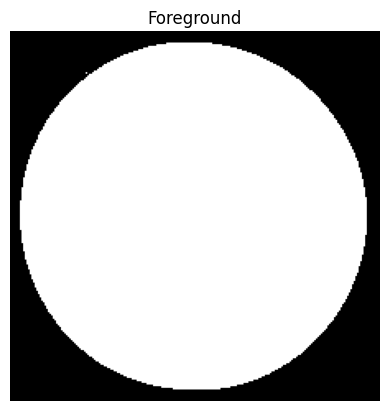

In [ ]:
import cv2;
import numpy as np;
 
img = cv2.imread("Images/koin2.png", cv2.IMREAD_GRAYSCALE)

th, im_th = cv2.threshold(img, 220, 255, cv2.THRESH_BINARY_INV)
 
im_floodfill = im_th.copy()
 
h, w = im_th.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)
 
cv2.floodFill(im_floodfill, mask, (0,0), 255)
 
im_floodfill_inv = cv2.bitwise_not(im_floodfill)
 
im_out = im_th | im_floodfill_inv
 
show("Thresholded Image", im_th)
show("Floodfilled Image", im_floodfill)
show("Inverted Floodfilled Image", im_floodfill_inv)
show("Foreground", im_out)

## 7) Thinning (penulangan / skeleton)
Implementasi Zhang-Suen Thinning murni numpy. Alternatif: jika punya `opencv-contrib-python` bisa gunakan `cv2.ximgproc.thinning`.

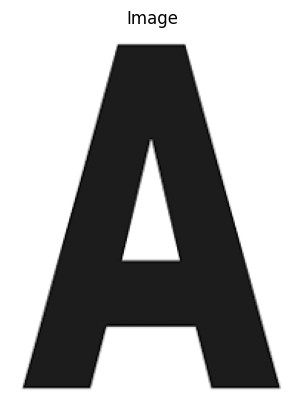

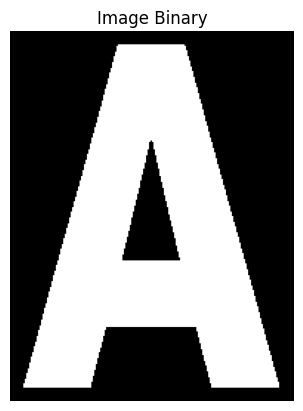

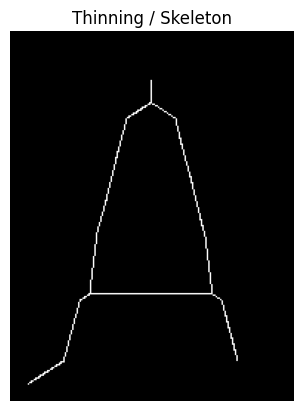

In [ ]:
def zhang_suen_thinning(image):
    bin_img = (image > 0).astype(np.uint8)
    changed = True
    while changed:
        changed = False
        to_remove = []
        rows, cols = bin_img.shape
        # Pass 1
        for i in range(1, rows-1):
            for j in range(1, cols-1):
                if bin_img[i, j] != 1:
                    continue
                n = [bin_img[i-1,j], bin_img[i-1,j+1], bin_img[i,j+1], bin_img[i+1,j+1],
                     bin_img[i+1,j], bin_img[i+1,j-1], bin_img[i,j-1], bin_img[i-1,j-1]]
                C = sum(n)
                if C < 2 or C > 6:
                    continue
                transitions = sum((n[k] == 0 and n[(k+1) % 8] == 1) for k in range(8))
                if transitions != 1:
                    continue
                if n[0] * n[2] * n[4] != 0:
                    continue
                if n[2] * n[4] * n[6] != 0:
                    continue
                to_remove.append((i, j))
        if to_remove:
            changed = True
            for (i, j) in to_remove:
                bin_img[i, j] = 0
        # Pass 2
        to_remove = []
        for i in range(1, rows-1):
            for j in range(1, cols-1):
                if bin_img[i, j] != 1:
                    continue
                n = [bin_img[i-1,j], bin_img[i-1,j+1], bin_img[i,j+1], bin_img[i+1,j+1],
                     bin_img[i+1,j], bin_img[i+1,j-1], bin_img[i,j-1], bin_img[i-1,j-1]]
                C = sum(n)
                if C < 2 or C > 6:
                    continue
                transitions = sum((n[k] == 0 and n[(k+1) % 8] == 1) for k in range(8))
                if transitions != 1:
                    continue
                if n[0] * n[2] * n[6] != 0:
                    continue
                if n[0] * n[4] * n[6] != 0:
                    continue
                to_remove.append((i, j))
        if to_remove:
            changed = True
            for (i, j) in to_remove:
                bin_img[i, j] = 0
    return (bin_img * 255).astype(np.uint8)

img = cv2.imread('Images/a.png', cv2.IMREAD_GRAYSCALE)

_, img_th = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV) 
th = zhang_suen_thinning(img_th)
show("Image", img)
show("Image Binary", img_th) 
show("Thinning / Skeleton", th)


## 8) Morphological Reconstruction
Contoh Opening by Reconstruction (grayscale) menggunakan iterasi dilasi dibatasi mask (geodesic).


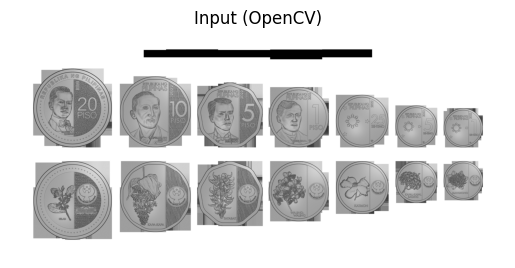

In [ ]:
import numpy as np, cv2, matplotlib.pyplot as plt, os

def show_gray(title, im, vmin=0, vmax=1):
    plt.figure(); plt.imshow(np.clip(im,0,1), cmap='gray', vmin=vmin, vmax=vmax)
    plt.title(title); plt.axis('off'); plt.show()

def to01(u8):
    return (u8.astype(np.float32) / 255.0)

INPUT_PATH = "Images/NGCCoins.png"  

if INPUT_PATH and os.path.isfile(INPUT_PATH):
    img_u8 = cv2.imread(INPUT_PATH, cv2.IMREAD_GRAYSCALE)
else:
    H, W = 360, 540
    rng = np.random.default_rng(7)
    y, x = np.indices((H, W))
    base = (0.2 + 0.6*(x/W)).astype(np.float32)
    noise = cv2.GaussianBlur(rng.normal(0,1,(H,W)).astype(np.float32), (0,0), 1.2)*0.03
    img = np.clip(base + noise, 0, 1)
    cv2.rectangle(img, (120,100), (420,280), 0.65, -1)
    for cx,cy,r in [(200,160,9),(260,210,7),(300,190,5),(380,230,6)]: cv2.circle(img,(cx,cy),r,0.95,-1)
    for cx,cy,r in [(240,200,8),(340,220,6)]: cv2.circle(img,(cx,cy),r,0.35,-1)
    img_u8 = (img*255).astype(np.uint8)

img = to01(img_u8) 
show_gray("Input (OpenCV)", img)


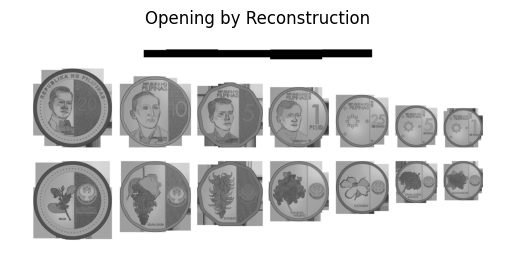

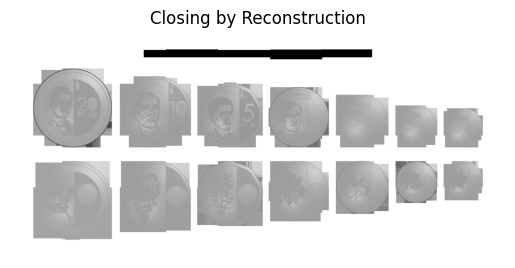

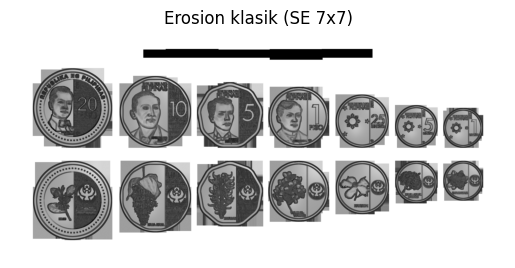

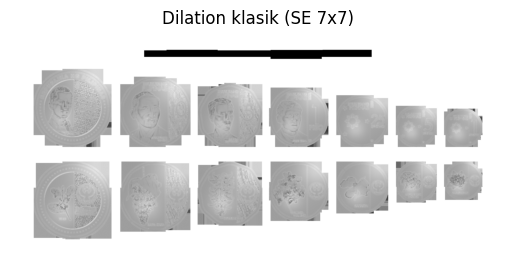

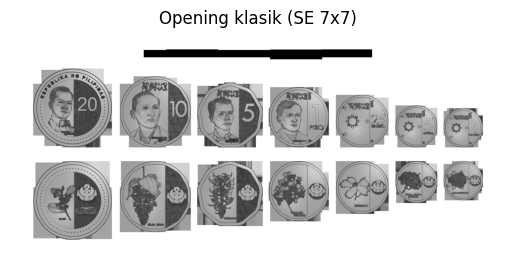

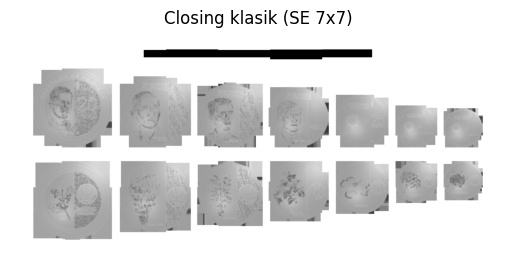

In [ ]:
import numpy as np, cv2, matplotlib.pyplot as plt

def recon_by_dilation(marker01, mask01, se=None, max_iters=2000):
    if se is None: se = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
    prev = marker01.astype(np.float32); mask01 = mask01.astype(np.float32)
    for _ in range(max_iters):
        cur = np.minimum(cv2.dilate(prev, se), mask01)
        if np.array_equal(cur, prev): break
        prev = cur
    return prev

def recon_by_erosion(marker01, mask01, se=None, max_iters=2000):
    inv = lambda x: 1.0 - x
    return inv(recon_by_dilation(inv(marker01), inv(mask01), se=se, max_iters=max_iters))

def opening_by_reconstruction(img01, se_erode, se_recon=None):
    if se_recon is None: se_recon = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
    eroded = cv2.erode((img01*255).astype(np.uint8), se_erode).astype(np.float32)/255.0
    return recon_by_dilation(eroded, img01, se=se_recon)

def closing_by_reconstruction(img01, se_dilate, se_recon=None):
    if se_recon is None: se_recon = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
    inv = 1.0 - img01
    return 1.0 - opening_by_reconstruction(inv, se_dilate, se_recon=se_recon)

def show_gray(title, im, vmin=0, vmax=1):
    plt.figure(); plt.imshow(np.clip(im,0,1), cmap='gray', vmin=vmin, vmax=vmax)
    plt.title(title); plt.axis('off'); plt.show()

se_bg   = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(31,31))
se_geo  = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))

obr = opening_by_reconstruction(img, se_bg,  se_recon=se_geo)
cbr = closing_by_reconstruction(img, se_bg,  se_recon=se_geo)

show_gray("Opening by Reconstruction", obr)
show_gray("Closing by Reconstruction", cbr)

se_basic = cv2.getStructuringElement(cv2.MORPH_RECT,(7,7))
img_u8   = (np.clip(img,0,1)*255).astype(np.uint8)
eroded   = cv2.erode(img_u8,  se_basic).astype(np.float32)/255.0
dilated  = cv2.dilate(img_u8, se_basic).astype(np.float32)/255.0
opened_c = cv2.morphologyEx(img_u8, cv2.MORPH_OPEN,  se_basic).astype(np.float32)/255.0
closed_c = cv2.morphologyEx(img_u8, cv2.MORPH_CLOSE, se_basic).astype(np.float32)/255.0

show_gray(f"Erosion klasik (SE {se_basic.shape[1]}x{se_basic.shape[0]})", eroded)
show_gray(f"Dilation klasik (SE {se_basic.shape[1]}x{se_basic.shape[0]})", dilated)
show_gray(f"Opening klasik (SE {se_basic.shape[1]}x{se_basic.shape[0]})", opened_c)
show_gray(f"Closing klasik (SE {se_basic.shape[1]}x{se_basic.shape[0]})", closed_c)


## 9) Top-hat & Black-hat
Menggunakan `cv2.morphologyEx` dengan `MORPH_TOPHAT` dan `MORPH_BLACKHAT`.

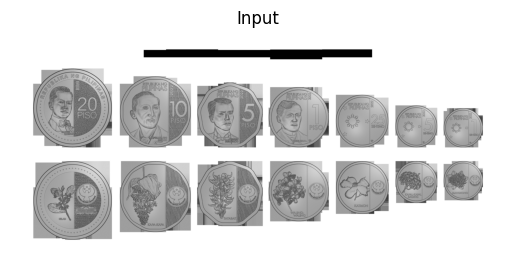

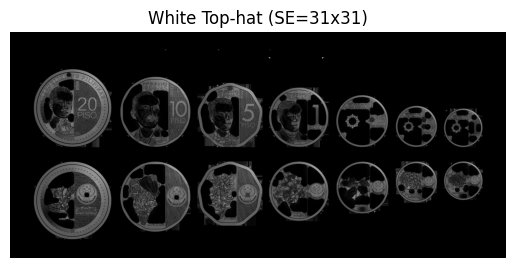

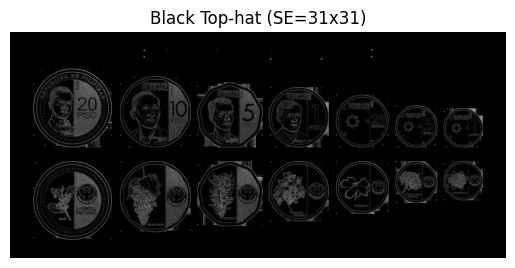

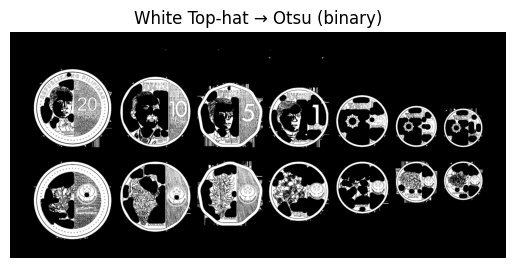

In [ ]:
import os, numpy as np, cv2, matplotlib.pyplot as plt

def show_gray(t, a, v=(0,1)):
    plt.figure(); plt.imshow(np.clip(a,0,1), cmap='gray', vmin=v[0], vmax=v[1])
    plt.title(t); plt.axis('off'); plt.show()

try:
    img  
except NameError:
    INPUT_PATH = None  
    if INPUT_PATH and os.path.isfile(INPUT_PATH):
        img_u8 = cv2.imread(INPUT_PATH, cv2.IMREAD_GRAYSCALE)
        img = (img_u8.astype(np.float32)/255.0)
    else:
        H, W = 360, 540
        rng = np.random.default_rng(7)
        y, x = np.indices((H, W))
        base = (0.2 + 0.6*(x/W)).astype(np.float32)
        noise = cv2.GaussianBlur(rng.normal(0,1,(H,W)).astype(np.float32),(0,0),1.2)*0.03
        img = np.clip(base + noise, 0, 1)
        cv2.rectangle(img,(120,100),(420,280),0.65,-1)
        for cx,cy,r in [(200,160,9),(260,210,7),(300,190,5),(380,230,6)]: cv2.circle(img,(cx,cy),r,0.95,-1)

SE_SIZE = 31  
se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (SE_SIZE, SE_SIZE))

img_u8 = (np.clip(img,0,1)*255).astype(np.uint8)

wth_u8 = cv2.morphologyEx(img_u8, cv2.MORPH_TOPHAT,  se)  
bth_u8 = cv2.morphologyEx(img_u8, cv2.MORPH_BLACKHAT, se)  

wth = wth_u8.astype(np.float32)/255.0
bth = bth_u8.astype(np.float32)/255.0

show_gray("Input", img)
show_gray(f"White Top-hat (SE={SE_SIZE}x{SE_SIZE})", wth)
show_gray(f"Black Top-hat (SE={SE_SIZE}x{SE_SIZE})", bth)

_, wth_bin = cv2.threshold(wth_u8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.figure(); plt.imshow(wth_bin, cmap='gray', vmin=0, vmax=255)
plt.title("White Top-hat → Otsu (binary)"); plt.axis('off'); plt.show()


## 10) Geodesic Dilation (via reconstruction)
Menggunakan fungsi reconstruction yang sama (marker ditingkatkan dilasi tetapi dibatasi oleh mask).

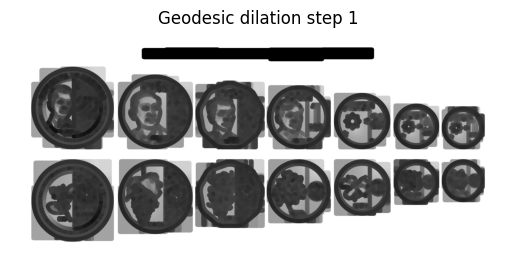

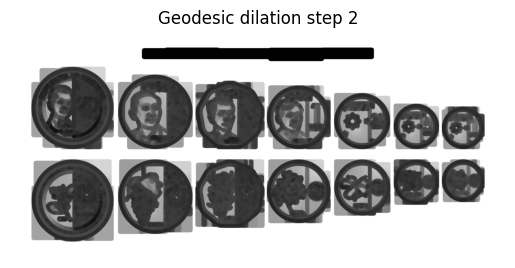

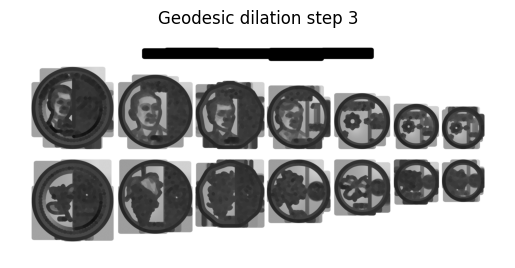

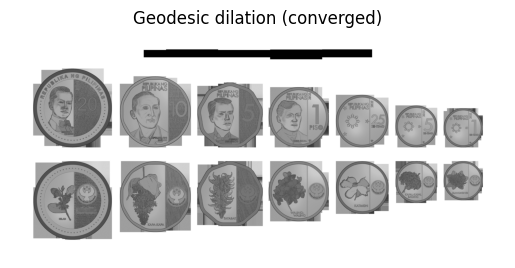

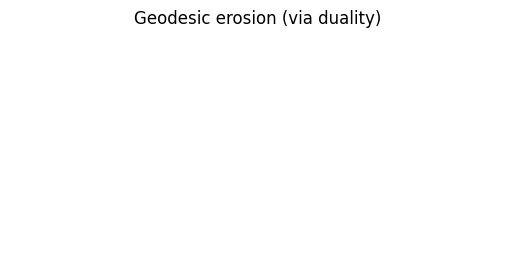

In [ ]:
import numpy as np, cv2, matplotlib.pyplot as plt

def show_gray(title, im, v=(0,1)):
    plt.figure(); plt.imshow(np.clip(im,0,1), cmap='gray', vmin=v[0], vmax=v[1])
    plt.title(title); plt.axis('off'); plt.show()

def recon_by_dilation(marker, mask, se=None, max_iters=2000):
    if se is None: se = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
    prev = marker.astype(np.float32); mask = mask.astype(np.float32)
    for _ in range(max_iters):
        cur = np.minimum(cv2.dilate(prev, se), mask)
        if np.array_equal(cur, prev): break
        prev = cur
    return prev

def recon_by_erosion(marker, mask, se=None, max_iters=2000):
    inv = lambda x: 1.0 - x
    return inv(recon_by_dilation(inv(marker), inv(mask), se, max_iters))

se_geo = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))

marker0 = cv2.erode((img*255).astype(np.uint8), se_bg).astype(np.float32)/255.0
mask    = img

g1 = np.minimum(cv2.dilate(marker0, se_geo), mask)
g2 = np.minimum(cv2.dilate(g1,      se_geo), mask)
g3 = np.minimum(cv2.dilate(g2,      se_geo), mask)
g_final = recon_by_dilation(marker0, mask, se=se_geo)  

show_gray("Geodesic dilation step 1", g1)
show_gray("Geodesic dilation step 2", g2)
show_gray("Geodesic dilation step 3", g3)
show_gray("Geodesic dilation (converged)", g_final)

ge_erode_final = recon_by_erosion(marker=np.ones_like(img, np.float32), mask=img, se=se_geo)
show_gray("Geodesic erosion (via duality)", ge_erode_final)


## 11) Bonus: Template Matching (biner) via cv2.matchTemplate
Menggunakan metode korelasi normalisasi.

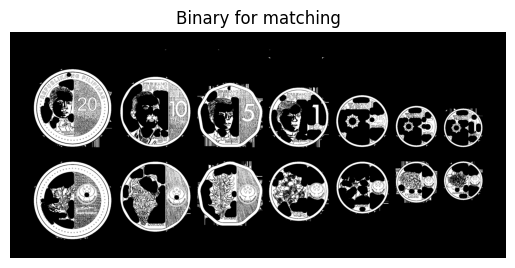

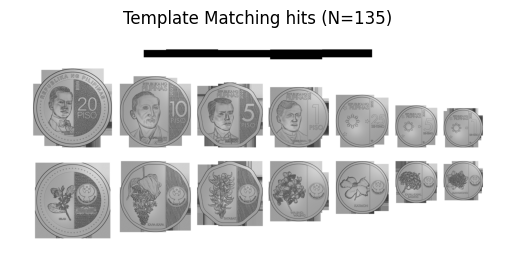

Template size: 548x548, detections: 135


In [ ]:
import numpy as np, cv2, matplotlib.pyplot as plt


wtr_u8 = (np.clip(img - cv2.morphologyEx((img*255).astype(np.uint8), cv2.MORPH_OPEN, se_bg).astype(np.float32)/255.0, 0, 1)*255).astype(np.uint8)
_, mask_rec = cv2.threshold(wtr_u8, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.figure(); plt.imshow(mask_rec, cmap='gray', vmin=0, vmax=255)
plt.title("Binary for matching"); plt.axis('off'); plt.show()

cnts, _ = cv2.findContours(mask_rec, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
x,y,w,h = cv2.boundingRect(cnts[0])
template = mask_rec[y:y+h, x:x+w]

res = cv2.matchTemplate(mask_rec, template, cv2.TM_CCOEFF_NORMED)
ys, xs = np.where(res >= 0.6)  


vis = (np.clip(img,0,1)*255).astype(np.uint8).copy()
for (cx, cy) in zip(xs, ys):
    cv2.rectangle(vis, (cx, cy), (cx+w, cy+h), (255,), 1)

plt.figure(); plt.imshow(vis, cmap='gray', vmin=0, vmax=255)
plt.title(f"Template Matching hits (N={len(xs)})"); plt.axis('off'); plt.show()

print(f"Template size: {w}x{h}, detections: {len(xs)}")


---
**Catatan:** semua contoh kini menggunakan OpenCV (`cv2`) dan implementasi manual (Zhang-Suen thinning, morphological reconstruction) tanpa `scikit-image` atau `scipy`. Setiap gambar ditampilkan satu per plot sederhana.